In [278]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.3.1+cpu


In [279]:
#!pip install torch_geometric

# Optional dependencies:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [280]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, radius_graph
import enum
import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import ReLU, LeakyReLU, Sigmoid
from torch.nn import LayerNorm
import torch.nn.functional as F
from torch import optim
import torch_scatter
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import trange
import random
import copy

In [281]:
# Start seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Graph construction

In [282]:
# Create folder called Data
data_path = r"Data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Create folder called Model
model_path = r"model"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [283]:
# Acceleration data
df = pd.read_csv(r"Data\Data4.csv")
time = df["0"].values
df.drop(columns=["0"], inplace=True)

# Coordinates data
df_coord = np.array([[2.5, 30*i] for i in range(0, df.shape[1])])

# Node type
node_type = np.zeros(df_coord.shape[0])
node_type[[-1,0]] = 1

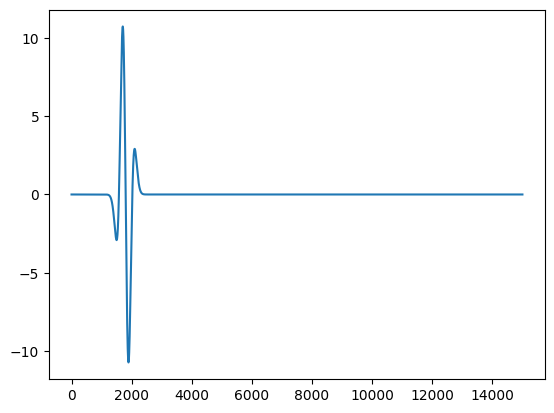

In [284]:
# Input acceleration
freq1 = 1.75 # Freq1
t01 = 1.8 # Time Shift
t = time
wave = -2*freq1**2*np.pi**2*np.exp(-freq1**2*np.pi**2*(t01 - t)**2)*(t01 - t)*(2*freq1**2*np.pi**2*t01**2 - 4*freq1**2*np.pi**2*t01*t + 2*freq1**2*np.pi**2*t**2 - 3)
# Create acceleration array input
input_acc = np.zeros_like(df.values)
input_acc[:,0] = wave
input_acc = np.vstack((np.zeros(input_acc.shape[1]), input_acc))


plt.plot(input_acc[:,0])
plt.show()

In [285]:
# Initialize the data_list
data_list = []

# Time step
dt = 1e-4

# Spacing
dx = 30

# Establish some data
number_trajectories = 1
number_ts = -1

# Create file_path
data_path = "Data"
save_data = True

for k in range(df.shape[0]):
    if k == number_ts:
        break

    # Get acceleration
    acceleration_target = torch.tensor(df.iloc[k].values, dtype=torch.float).unsqueeze(1)
    acceleration_input = torch.tensor(input_acc[k], dtype=torch.float).unsqueeze(1)

    # Get node type
    node_type_input = torch.tensor(node_type, dtype=torch.float)

    # Get edge_index
    coordinates = torch.tensor(df_coord, dtype=torch.float)
    edges_index = radius_graph(coordinates, r=1.1*dx, loop=False).squeeze(0).type(torch.long)

    # Get edge_attr
    u_i = coordinates[edges_index[0]]
    u_j = coordinates[edges_index[1]]
    u_ij = u_i - u_j
    u_ij_norm = torch.norm(u_ij, p=2, dim=1, keepdim=True)
    edge_attr = torch.cat([u_ij, u_ij_norm], dim=-1).type(torch.float)

    # Store data
    data_list.append(Data(x=acceleration_input, edge_index=edges_index,
                          edge_attr=edge_attr, y=acceleration_target, node_type=node_type_input))

print("Done collecting data!")

# Save
if save_data:
  torch.save(data_list, os.path.join(data_path, "Data4.pt"))
  print("Data saved!")
  print("Output Location: ", os.path.join(data_path, "Data4.pt"))

Done collecting data!
Data saved!
Output Location:  Data\Data4.pt


# Normalization
Normalization is necessary for the features and output parameters to zero mean and unit variance in order to stabilize training. The method defined below, get_stats(), is run before training. It accepts the processed data_list, calculates the mean and standard deviation for the node features, edge features, and node outputs, and normalizes these using the calculated statistics.

In [286]:
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalizes these using the calculated statistics.
    '''

    # Mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    # Mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    # Mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    # Define the maximum number of accumulations to perform such that we do
    # not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge = 0
    num_accs_y = 0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        # Add to the mean and std vectors for the node features
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        # Add to the mean and std vectors for the edge features
        mean_vec_edge +=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge +=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge +=dp.edge_attr.shape[0]

        # Add to the mean and std vectors for the node outputs
        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_x = torch.nan_to_num(mean_vec_x, nan=0.0)
    std_vec_x = torch.nan_to_num(std_vec_x, nan=1.0)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_edge = torch.nan_to_num(mean_vec_edge, nan=0.0)
    std_vec_edge = torch.nan_to_num(std_vec_edge, nan=1.0)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_vec_y = torch.nan_to_num(mean_vec_y, nan=0.0)
    std_vec_y = torch.nan_to_num(std_vec_y, nan=1.0)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

# Encoder

In [287]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim):
        super(Encoder, self).__init__()

        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear(input_dim_edge , hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                LayerNorm(hidden_dim))

    def forward(self, x, edge_attr):
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        return x, edge_attr

# Decoder

In [288]:
class Decoder(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim_node):
        super(Decoder, self).__init__()

        self.node_decoder = Sequential(Linear(hidden_dim, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, output_dim_node))

    def forward(self, x):
        return self.node_decoder(x)


# Update
In this case, since we do not know which information we require to have for the GNN, let's compute a NN for the update step

In [289]:
class Update(torch.nn.Module):
    def __init__(self, input_X, input_Y, hidden_dim, output_X=None):
        super(Update, self).__init__()

        if output_X is None:
            output_X = input_X

        self.update = Sequential(Linear(input_X + input_Y, hidden_dim),
                                Sigmoid(),
                                Linear(hidden_dim, output_X))

    def forward(self, x, y):
        return self.update(torch.cat([x, y], dim=-1))

# GNN

In [290]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()

        self.num_layers = args.num_layers

        # Encoder
        self.encoder = Encoder(input_dim_node, input_dim_edge, hidden_dim)

        # Processor
        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))

        # Decoder
        self.decoder = Decoder(hidden_dim, output_dim)

        # Update
        self.update = Update(input_dim_node, output_dim, hidden_dim)

    def build_processor_model(self):
        return ProcessorLayer

    def forward(self, data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):

        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        # Normalize the input data
        x_norm = normalize(x,mean_vec_x,std_vec_x)
        edge_attr = normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Encoder
        x, edge_attr = self.encoder(x_norm, edge_attr)

        # Processor
        for i in range(self.num_layers):
            x, edge_attr = self.processor[i](x, edge_index, edge_attr)

        # Decoder
        x = self.decoder(x)

        # Update
        x = self.update(x_norm, x)

        return x

    def loss(self, pred, inputs, mean_vec_y, std_vec_y, mean_vec_x, std_vec_x, loss_function=nn.MSELoss()):

        # Normalize the output data
        y = inputs.y
        y = normalize(y,mean_vec_y,std_vec_y)

        # Get node type
        node_type = inputs.node_type

        y = y[node_type==1]
        pred = pred[node_type==1]

        # Calculate the sqrt loss
        loss = loss_function(pred, y)

        return loss

# ProcessorLayer Class: Edge Message Passing, Aggregation, and Updating

Now let's implement the processor, which overrides "[MessagePassing](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)" base class. Following the prototype of the base class, we need to implement three main methods, namely message passing, aggregation, and updating. Also, two types of MLP layers, namely node MLP and edge MLP, are defined and used during the construction of processor, whose details will be given in the cell bellow.

Essentailly, our processor class serves as the GNN layers composed of message passing, aggregation, and updating, updating information at each layer of the computational graph for each node. The message passing process can be described as:

1.   **Message passing**

Initiated by the propagate function, the message function most generally calculates messages, m, for edge u at layer l with function MSG given previous embeddings h_u:
$$m_u^{(l)}=MSG^{(l)}(h_u^{(l-1)})$$

Note that for MeshGraphNets, messages are calculated for edges and passed to nodes. This function thus takes edge embeddings and the adjacent node embeddings and concatenates them. These concatenated previous embeddings constitute h_u above. These are then put through an MLP (our MSG function) to give the final messages, m_u, which are passed to the aggregate function.

2.   **Aggregation**

Aggregation takes the updated edge embeddings and aggregates then over the connectivity matrix indexing using sum reduction. Most generally, we have:

$$h_v^{(l)}=AGG^{(l)}(\{m_u^{(l)},u\in N(v)\})$$

For MeshGraphNets, aggregation (AGG) for node v is sum over the neighbor nodes. However, there is also an additional aggregation step: aggregating with the self embedding. This is done outside of the aggregation function, in the forward function after the return of propagate:

$$h_v^{(l)}=\{h_v^{(l-1)},AGG^{(l)}(\{m_u^{(l)},u\in N(v)\})\}$$

3.   **Updating**

The nodes embeddings are finally updated by passing $h_v^{(l)}$ through the node MLP with a skip connection. This is most generally written as:

$$h_v^{(l)}=Processor(h_v^{(l)})$$

Where for us the Processor is an MLP.


In [291]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ProcessorLayer, self).__init__(**kwargs)

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear(3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear(2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()


    def forward(self, x, edge_index, edge_attr, size=None):

        out, updated_edges = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size) # Out has the shape of [E, out_channels]
        updated_nodes = torch.cat([x, out], dim=1) # Complete the aggregation through self-aggregation
        updated_nodes = x + self.node_mlp(updated_nodes) # Residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):

        updated_edges = torch.cat([x_i, x_j, edge_attr], dim=1) # Shape of [E, 3*in_channels]
        updated_edges = self.edge_mlp(updated_edges)

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges



In [292]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

## Check

In [293]:
args = {
    "num_layers": 2,
    "hidden_dim": 64,
    "output_dim": 1
}

args = objectview(args)
model = MeshGraphNet(1, 3, 64, 1, args)
loss_function = nn.MSELoss()

In [294]:
stats = get_stats(data_list)
mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y = stats


input_try = data_list[-1]
pred = model(input_try, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge)
loss = model.loss(pred, input_try, mean_vec_y, std_vec_y, mean_vec_x, std_vec_x, loss_function)
print("Loss:", loss.item())
print("Model works!")

Loss: 0.05628581717610359
Model works!


# Training

In [307]:
def train(dataset, val_dataset, stats_list, args, device="cuda"):

    df_train = pd.DataFrame(columns=["Epoch", "Loss", "Val_Loss"])

    # Define the model name
    model_name = 'model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    save_path = os.path.join(model_path, model_name+".pt")

    # DataLoader
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=args.shuffle)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=args.shuffle)

    # The statistics of the data decomposed
    [mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y] = stats_list
    (mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y) = (mean_vec_x.to(device), std_vec_x.to(device), mean_vec_edge.to(device), std_vec_edge.to(device), mean_vec_y.to(device), std_vec_y.to(device))

    # Build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    output_dim = 1

    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, output_dim, args).to(device)
    scheduler, optimizer = build_optimizer(args, model.parameters())

    # Training
    losses = []
    best_loss = np.inf
    best_epoch = -1
    val_losses = []
    best_model = None

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops = 0
        for batch in loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            pred = model(batch, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge)
            loss = model.loss(pred, batch, mean_vec_y, std_vec_y, mean_vec_x, std_vec_x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if scheduler is not None:
                scheduler.step()

            num_loops += 1

        total_loss /= num_loops
        losses.append(total_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        num_loops = 0
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch.to(device)
                val_pred = model(val_batch, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge)
                val_loss += model.loss(val_pred, val_batch, mean_vec_y, std_vec_y, mean_vec_x, std_vec_x).item()
                num_loops += 1

        val_loss /= num_loops
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), save_path)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {total_loss} | Val Loss: {val_losses[-1]} ")

            # Validation loss
            model.eval()

            val_loss = 0
            num_loops = 0





        # Save losses
        df_train.loc[len(df_train)] = [epoch, total_loss, val_losses[-1]]



    return model, df_train



In [308]:
def test(dataset, stats_list, model, args):

    model.eval()

    test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=args.shuffle)
    test_losses = []
    results = []
    device = args.device

    # Unpack the statistics and move them to the device
    [mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y] = stats_list
    (mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y) = (
        mean_vec_x.to(device), std_vec_x.to(device), mean_vec_edge.to(device),
        std_vec_edge.to(device), mean_vec_y.to(device), std_vec_y.to(device)
    )

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge).to(device)
            loss = model.loss(pred, batch, mean_vec_y, std_vec_y, mean_vec_x, std_vec_x)
            test_losses.append(loss.item())
            results.append(pred * std_vec_y + mean_vec_y + batch.x * std_vec_x + mean_vec_x)

    test_loss = np.mean(test_losses)
    print(f"Test Loss: {test_loss}")

    return test_loss, results



# Start training

## Optimizer

In [309]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    elif args.opt_scheduler == 'exponential':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.opt_decay_rate)
    return scheduler, optimizer

In [310]:
for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 3,
         'batch_size': 2,
         'hidden_dim': 100,
         'epochs': 100,
         'opt': 'adam',
         'opt_scheduler': 'exponential',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'opt_decay_rate': 0.1 ** (1 / 5e6),
         'lr': 0.005,
         'train_size': 80,
         'val_size': 10,
         'test_size': 10,
         'device':'cpu',
         'shuffle': False,
         'save_velo_val': True,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [311]:
# Load dataset
dataset = torch.load("Data/Data4.pt")

In [312]:
# Separate between training and test
total_data_num = len(dataset)
train_size = int(total_data_num * args.train_size / 100)
val_size = int(total_data_num * args.val_size / 100)
test_size = total_data_num - train_size - val_size

train_data = dataset[:train_size]
val_data = dataset[train_size:train_size+test_size]
test_data = dataset[train_size+test_size:]

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Val size: ", len(val_data))

Train size:  12000
Test size:  1500
Val size:  1500


In [313]:
# Get stats for the training data, and normalize the data
stats_list = get_stats(train_data)

In [314]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [315]:
# Train
model, df_train = train(train_data, val_data, stats_list, args, device)

Training:   0%|          | 0/100 [08:27<?, ?Epochs/s]


KeyboardInterrupt: 

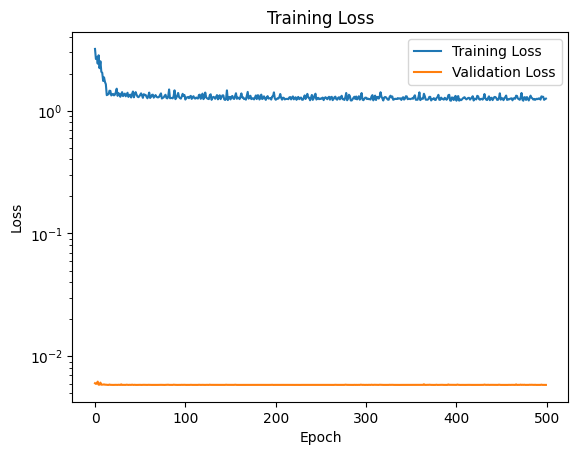

In [270]:
# Plot losses using seaborn
import seaborn as sns

sns.lineplot(x="Epoch", y="Loss", data=df_train, label="Training Loss")
sns.lineplot(x="Epoch", y="Val_Loss", data=df_train, label="Validation Loss")

# Y label in log scale
plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [302]:
# Test
test_loss, results = test(test_data, stats_list, model, args)

Test Loss: 0.04126559910923243


# Check output

In [303]:
def predict(dataset, model, stats_list, device="cuda"):
    model.eval()

    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    results = []

    # Unpack the statistics and move them to the device
    [mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y] = stats_list
    (mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y) = (
        mean_vec_x.to(device), std_vec_x.to(device), mean_vec_edge.to(device),
        std_vec_edge.to(device), mean_vec_y.to(device), std_vec_y.to(device)
    )

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge).to(device)
            results.append(pred * std_vec_y + mean_vec_y + batch.x * std_vec_x + mean_vec_x)

    return results

In [304]:
results = predict(dataset, model, stats_list, device)

# Convert to numpy
results = [result.cpu().numpy() for result in results]
results = np.array(results).squeeze()

# Extract from ground truth 
y = [data.y.cpu().numpy() for data in dataset]
y = np.array(y).squeeze()

In [305]:
# Select only first and final row
y = y[:,[0,-1]]
results = results[:,[0,-1]]

print(y.shape, results.shape)

(15000, 2) (15000, 2)


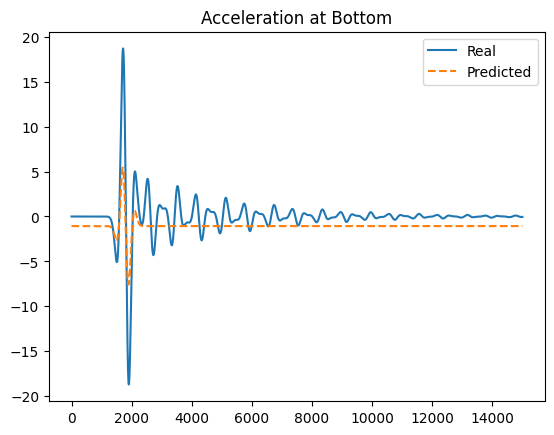

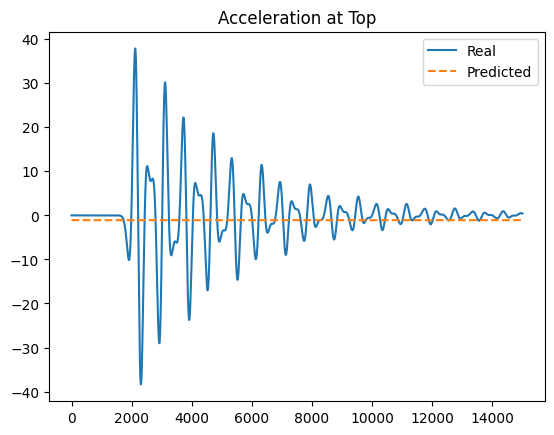

In [306]:
import matplotlib.pyplot as plt

# Plot the results
name=["Bottom", "Top"]

for i in range(y.shape[1]):
    plt.plot(y[:,i], label="Real")
    plt.plot(results[:,i], label="Predicted", linestyle="--")
    plt.title("Acceleration at " + name[i])
    plt.legend()
    plt.show()

In [174]:
# Save model
model_name = 'model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

# Save the model
# Create the folder
os.makedirs(args.checkpoint_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(args.checkpoint_dir, model_name + ".pt"))